In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

Caution: Just load the data already processed data a couple of lines below, don't run everything again. MEMORY ISSUES

### Load tokenized tweets

In [ ]:
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = pickle.load(f)

### Load word2vec model

In [ ]:
w2v_model = Word2Vec.load("../models/w2v_skipgram_w10.model")

### Embedd tweets

- First define a function that adds the individual words in each tweet together to form a vector representation of each tweet.

In [ ]:
# This function embedds tweets based on the sum of the vector representations of each word in the tweet
def embed_w2v_sum(tokens, w2v):
    
    # Get the index of the word vectors for each token in a tweet
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    
    # N is the number of tokens in tweet
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    
    # A tweet is represented by the sum of the vectors it contains
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    
    # Standardize the whole tweet by its norm
    a /= np.linalg.norm(a)
    return a


In [ ]:
# Use the function to embeedd the tweets
tweets_embedded = np.array([embed_w2v_sum(t, w2v_model) for t in tweets_tokenized])

# Save as numpy file for loading later
np.save("../data/tweets_embedded", tweets_embedded)

In [ ]:
# Free up some workspace
tweets_tokenized = None
w2v_model = None

## Visualize and Cluster Embedded Tweets

Let's start with taking some very interesting and/or offensive tweets and finding the most similar as well as dissimilar tweets to them.

We should also work on a subset, so let's take tweets with a higher number of retweets.

In [27]:
with open('../data/tweets_clean.pickle', 'rb') as f:
    tweet_df = pickle.load(f)
    
tweets_embedded = np.load("../data/tweets_embedded.npy")

In [28]:
# Clean tweet df first two columns and reset index
tweet_df.drop(columns=["Unnamed: 0"],inplace=True)

# Reset index
tweet_df.reset_index(drop=True, inplace=True)

Let's visualize some tweets first. We pick out two important accounts: KaniJJackson and Pamela_Moore13

In [20]:
# Get the corresponding subsets of the tweet df and embedded tweets, we will work with those now
tweetDf_subset = tweet_df[(tweet_df.user_screen_name == "KaniJJackson") | (tweet_df.user_screen_name == "Pamela_Moore13")].copy()

# Get subset of embedded tweets
tweet_embedded_subset = tweets_embedded[tweetDf_subset.index]



In [22]:
# Garbage collector

import gc
# Clear up the workspace, unfortunately I'm running out of memory
del tweet_df, tweets_embedded

gc.collect()

22226

Let's try to visualize this subset, maybe we already get a separation.

In [23]:
from utils.comparison import embedd_tSNE

In [24]:
d = embedd_tSNE(tweet_embedded_subset,pca_n =10, metric='cosine')

starting PCA
Done with PCA


In [25]:
tweetDf_subset["x"] = d[:,0]
tweetDf_subset["y"] = d[:,1]

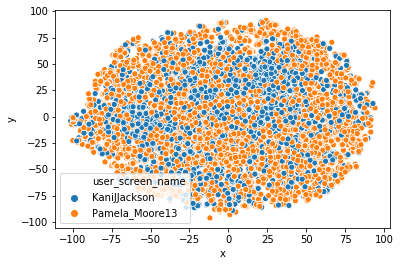

In [26]:
sns.scatterplot(data=tweetDf_subset, x= "x", y="y", hue = "user_screen_name")

Well this is really anything but a separation. On the other hand, project these tweets in two dimensions is really hard. t-SNE is really not supposed to be used for clustering, rather for visualization. Further, I think t-SNE picks up the hashtags (as intended to) which can be shared across users. Let's verify this quickly:

starting PCA
Done with PCA


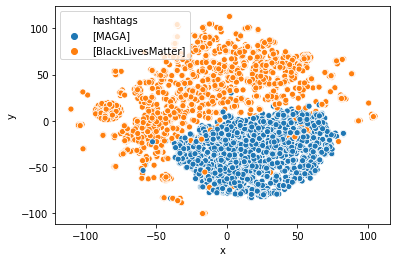

In [38]:
tweetDf_subset = tweet_df[(tweet_df.hashtags == "[MAGA]") | (tweet_df.hashtags == "[BlackLivesMatter]")].copy()

# Get subset of embedded tweets
tweet_embedded_subset = tweets_embedded[tweetDf_subset.index]

d = embedd_tSNE(tweet_embedded_subset,pca_n =10, metric='cosine')

tweetDf_subset["x"] = d[:,0]
tweetDf_subset["y"] = d[:,1]

sns.scatterplot(data=tweetDf_subset, x= "x", y="y", hue = "hashtags")